In [196]:
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

In [197]:
# lets load the data
df = pd.read_csv('course_ratings.csv')

In [198]:
#lets remove high rating rows
joined = df.drop(df[df['rating'] > 5].index)

In [199]:
# lets define catigorical vars
cat_vars = ['user','course','category','job','institution','state']
#coninuous vars
cont_vars = ['rating']

# df length
n = len(df)

# test percentage
testp = n*.2

#lets update features, categoricial should be category and continuous should be float32
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    
for v in cont_vars:
    joined[v] = joined[v].fillna(0).astype('float32')

In [200]:
# we have to convert all category variables into contiguous ones and save the look up table
lookup_table = {}
for c in cat_vars:
    uq = joined[c].unique()
    col2idx =  {o:i for i,o in enumerate(sorted(uq))}
    lookup_table[c] = col2idx
    joined[c] = joined[c].apply(lambda x: col2idx[x])

In [201]:
#lets save the mapper for later use
with open('models/data/lookup_table', 'wb') as fp:
    pickle.dump(lookup_table, fp)

In [202]:
#lets check lookup table
with open ('models/data/lookup_table', 'rb') as fp:
    lut_load = pickle.load(fp)

#lut_load

In [203]:
# create a test/train set split
joined, joined_test = train_test_split(joined, test_size=0.25)
df = joined.drop('rating', axis=1)
y = joined['rating']
df_test = joined_test.drop('rating', axis=1)

# create a validation set of ids
train_ratio = 0.75
train_size = int(len(df) * train_ratio)
val_idx = list(range(train_size, len(df)))

with open('models/data/val_idx', 'wb') as fp:
    pickle.dump(val_idx, fp)
    
with open('models/data/ratings', 'wb') as fp:
    pickle.dump(y, fp)

In [204]:
#final df , everything is numeric and continguous
with open('models/data/final_df', 'wb') as fp:
    pickle.dump(df, fp)

In [205]:
df.head(10)

,user,course,category,job,institution,state
162047,35829,44,7,6,9,39
31412,36782,172,7,6,11,44
138553,48382,126,7,6,9,32
166205,39621,193,9,12,2,28
157857,20518,207,7,6,6,41
170948,43076,203,7,6,14,42
12068,7788,174,7,6,9,58
18966,3587,174,7,6,14,31
73287,25060,70,0,28,11,30
93742,5218,197,0,28,8,45


In [206]:
#lets build the initial model
md = ColumnarModelData.from_data_frame("models/", val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [207]:
#build embedding matrix, matrices should be 1 bigger then the the number of categorical options to leave room for unknown
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
with open('models/data/emb_sizes', 'wb') as fp:
    pickle.dump(emb_szs, fp)

In [208]:
#build the learner, 
# .04 dropout on the embedding matrix
# 1000 and 500 nodes on 2 different layers
# .001 and .01 dropouts
# specifying the range of y (rating) to be 0-5
m = md.get_learner(emb_szs,0 ,0.4, 1, [200,100], [0.5,0.01],y_range=(0,5))

In [209]:
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 2605900)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 11000)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 8]),
                           ('trainable', True),
                           ('nb_params', 120)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 23]),
                           ('trainable', True),
                           ('nb_params', 1058)])),
             ('Embedding-5',
              OrderedDict([('input_sh

In [210]:
#lets find a learning rate
m.lr_find()

epoch      trn_loss   val_loss                                
    0      1.266841   1.272447  



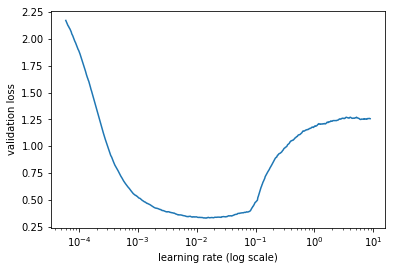

In [211]:
m.sched.plot(100)

In [212]:
lr = 1e-3

In [213]:
# Local
#m.fit(lr, 2, cycle_len=2)

In [214]:
# GPU
# lets fit the model, 50 epochs with restarts
m.fit(lr, 10, cycle_len=2, wds=1e-4)

epoch      trn_loss   val_loss                                
    0      0.254319   0.229277  
    1      0.189629   0.224951                                
    2      0.19514    0.216881                                
    3      0.142813   0.215873                                
    4      0.16849    0.21479                                 
    5      0.128826   0.213573                                
    6      0.159327   0.217304                                
    7      0.126337   0.213116                                
    8      0.15836    0.217652                                
    9      0.120887   0.212723                                
    10     0.153046   0.217135                                
    11     0.117215   0.213749                                
    12     0.151341   0.21705                                 
    13     0.11325    0.215457                                
    14     0.145294   0.218437                                
    15     0.112454   

[array([0.21618])]

In [215]:
m.save('mdl')

In [216]:
m.load('mdl')

In [217]:
x,y=m.predict_with_targs()

In [218]:
pred_test=m.predict(is_test=True)

In [219]:
joined_test['rating_pred'] = pred_test

In [220]:
joined_test[['rating','rating_pred']].head(10)

,rating,rating_pred
32827,4.62,4.463973
143695,4.59,4.018428
34386,3.77,3.390939
109667,2.81,3.370101
143434,3.77,3.690466
13310,4.46,4.250415
104836,4.54,3.771891
41875,3.85,4.121361
158435,4.55,4.178744
57442,4.15,3.728111


In [221]:
rms = sqrt(mean_squared_error(joined_test['rating'], joined_test['rating_pred']))

In [222]:
# we achieved a root mean squared error of .47
rms

0.4718462411061976

In [223]:
test_record = df_test.iloc[0]

In [224]:
joined_test.iloc[0]

user             31424
course              73
category             7
rating            4.62
job                  6
institution          0
state               24
rating_pred    4.46397
Name: 32827, dtype: object

In [225]:
cat = test_record[cat_vars].values.astype(np.int64)[None]
contin = test_record.drop(cat_vars).values.astype(np.float32)[None]

#Prediction
model = m.model
model.eval()
prediction = to_np(model(V(cat),[]))

In [226]:
prediction[0][0]

4.4639726

In [227]:
#model is ready, need to create simple api